По итогу при одинаковых настройках ruT5 показала лучшие результаты за 5 эпох. Поэтому этом, пусть скорость падения loss'а и уменьшилась, как мне кажется из этой модели ещё можно вытянуть более хорошие результаты

In [1]:
import torch
import uuid
import os
import evaluate
import numpy as np
from typing import Callable, Any
from datasets import Dataset
from transformers import (
    T5ForConditionalGeneration,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
from peft import (
    LoraConfig, # type: ignore
    get_peft_model, # type: ignore
    TaskType, # type: ignore
    AutoPeftModelForSeq2SeqLM # type: ignore
)
from tqdm import tqdm

In [2]:
train = Dataset.from_parquet('./__output__/matched_train.parquet')
test = Dataset.from_parquet('./__output__/matched_test.parquet')

In [21]:
model = T5ForConditionalGeneration.from_pretrained(
    'ai-forever/ruT5-base',
    device_map='cuda:0',
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(
    'ai-forever/ruT5-base',
    useFast=True
)

coll = DataCollatorForSeq2Seq(model=model, tokenizer=tokenizer)

# Сравнения промптов для генерации

In [4]:
test_model = AutoPeftModelForSeq2SeqLM.from_pretrained(
    './models/25494ed9-f307-4293-a192-80678a7aca3a/model',
    device_map='cuda:0',
    torch_dtype=torch.bfloat16
)

In [5]:
subset = test.select(np.random.randint(0, len(test), 4)) # type: ignore

In [6]:
for t in subset:
    print(t['text']) # type: ignore

Не разделяю восторженных отзывов. Для меня как минимум странно получить ниблер в простом зип пакете, без заводской упаковки, без минимальной информации по товару и обязательной по закону маркировки.. Я не рискнула оставить и уж тем более дать в пользование этот ниблер своему ребёнку...Тому, кто с этим не заморачивается,думаю, понравится. Внешне симпатичный, защелка крепкая. 
Заказала давно поводок, отзыв специально оставляю сейчас. Поводок отлично справляется. Я очень боялась что не выдержит, но все оказалось прекрасно! Собака 35 кг, может сильно потянуть поводок выдерживает. А у кого собака не воспитана и грызёт амуницию, виноват не поводок.
Здравствуйте. Скажите пожалуйста, когда появятся в продаже пиджаки размер xs?
Добрый день! Разницы нет. В карточке товара по ошибке задублирован размер.Рост модели - 170 см. Приятных покупок!


In [7]:
for t in subset:
    print(t['target_text']) # type: ignore

Не думала, что придётся писать отрицательный отзыв. К самому товару притензий нет, а вот от упаковки я в шоке. Её вообще нет. Футляр поцарапаный и на крышке дурацкая наклейка, которую я кое как убрала, и теперь крышка липкая. Неужели такая проблема завернуть в полиэтилен? Думаю, что это не слишком  затратно для вас. Хорошо, что брала не на подарок. Вообщем неприятно от такого отношения к заказам.
Начитавшись  положитеных отзывов....заказала коврик для резки.  Пришёл заказ с задержкой,  да это и не главное, зато  у меня появился новенький зелёный мат для работы. А самое интересное было далее....при использовании коврика  выяснилось,  что он прорезается полностью,  я в шоке! Для каких целей он тогда? Смотреть и любоваться? Такого я ещё не видела, мой старый коврик прослужил верой и правдой 5 лет и ещё живой....
НЕ РЕКОМЕНДУЮ К ПОКУПКЕ !!!!
Здравствуйте! А когда поступит в продажу размер xs?
Добрый день! Длина изделия по спинке для 42 размера - 54 см. Приятных покупок!


In [8]:
def make_full_target_promt(e):
    return f'''
ответчик: {e['target_responder']}
тип: {e['target_type']}
название: {e['target_product_name']}
категория 2: {e['target_product_category_2']}
цвет: {e['target_product_color']}
бренд: {e['target_product_brand']}
описание: {e['target_product_description']}
токсичность: {e['toxicity']}
эиоциональность: {e['emotions']}
текст: {e['text']}
    '''


def make_full_promt(e):
    return f'''
ответчик: {e['responder']}
тип: {e['type']}
название: {e['product_name']}
категория 2: {e['product_category_2']}
цвет: {e['product_color']}
бренд: {e['product_brand']}
описание: {e['product_description']}
токсичность: {e['toxicity']}
эиоциональность: {e['emotions']}
текст: {e['text']}
    '''


def make_text_promt(e):
    return f'''
текст: {e['text']}
    '''

In [9]:
def generate_res(e, promt_make: Callable[[Any], str]):
    model_in = tokenizer(
        promt_make(e),
        truncation=True,
        max_length=1400,
        return_tensors='pt'
    ).to('cuda:0')

    model_out = test_model.generate(
        **model_in,
        max_new_tokens=300,
        top_k=1,
        do_sample=True,
    )[0]

    return tokenizer.decode(model_out, skip_special_tokens=True)

In [10]:
for t in subset:
    print(generate_res(t, make_full_target_promt))

Не разделяю восторженных отзывов. Не ожидала, что будет так много восторженных отзывов. Но, к сожалению, не могу не оценить. На фото видно, что пудра не сливается, а сливается. На фото видно, что пудра не сливается. На фото видно, что она не сливается. Но, видимо, это не пудра, а пудра.
Коврик отличный, но я очень боялась, что не выдержит. Но, к сожалению, не выдержала. На мой взгляд, это не очень удобно. На мой взгляд, это не очень удобно. На мой взгляд, это не очень удобно. Но, к сожалению, не очень удобно. На мой взгляд, это не очень удобно.
Здравствуйте, когда появятся в продаже пиджаки размера xs?
Добрый день! Размер модели - 170 см.


In [11]:
for t in subset:
    print(generate_res(t, make_full_promt))

Не разделяю восторженных отзывов. Ниблер пришел в ужасном состоянии. Не знаю, как можно так относиться к покупателям. Но я не могу не согласиться с тем, что он не соответствует заявленному. Не знаю, как можно так относиться к покупателям. Но я очень довольна покупкой.
Поводок отличный, собака не боится, что не выдержит. Но я очень боялась, что не выдержит. Но, к сожалению, не выдержала. Собака не боится, не боится, не выскакивает, не выскакивает, не выскакивает, не выскакивает, не выскакивает, не выскакивает, не выскакивает, не выскакивает, не выскакивает, не выскакивает.
Здравствуйте, когда появятся в продаже пиджаки размера xs?
Добрый день! Размер модели - 170 см.


In [12]:
for t in subset:
    print(generate_res(t, make_text_promt))

Не разделяю восторженных отзывов. Не разделяю восторженных отзывов. Не разделяю восторженных отзывов. Не могу не оценить качество ниблера. Не знаю, как можно получить ниблер без заводской упаковки, без заводской упаковки. Не знаю, как можно получить такой ниблер без заводской упаковки.
Заказывала поводок, очень довольна. Собака очень довольна. Поводок отличный, очень довольна покупкой. Поводок отличный, собака не боится, не тянет, не тянет, не тянет. Поводок не тянет, не тянет, не тянет, не тянет. Поводок не тянет, не тянет, не тянет, не тянет.
Здравствуйте. Когда появятся пиджаки размер xs?
Добрый день! Приятных покупок! Приятных покупок!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


В целом, модель улавливает и использует информацию из дополнительных полей, пусть и со своими нюансами, вызванными несовершенством датасета. Как мне кажется, можно продолжить использование такого подхода к формированию промпта

In [13]:
del subset
del test_model

# Train

In [22]:
peft_conf = LoraConfig(
    TaskType.SEQ_2_SEQ_LM,
    r=64,
    lora_alpha=32,
    target_modules=['q', 'v'],
    lora_dropout=0.05,
    bias='none',
    inference_mode=False
)

peft_model = get_peft_model(model, peft_conf)

Из-за того, что описание в некоторых редких случаях может быть очень длинным, предлагаю обрезать его по колличеству слов, разделенных пробелом.

In [15]:
def preprocess(e):
    out = tokenizer(
        f'''
ответчик: {e['target_responder']}
тип: {e['target_type']}
название: {e['target_product_name']}
категория 2: {e['target_product_category_2']}
цвет: {e['target_product_color']}
бренд: {e['target_product_brand']}
описание: {' '.join(e['target_product_description'].split(' ')[:250])}
токсичность: {e['toxicity']}
эиоциональность: {e['emotions']}
текст: {e['text']}
        ''',
        truncation=True,
        max_length=1500,
        return_tensors='pt'
    )

    out['input_ids'] = out['input_ids'][0] # type: ignore
    out['attention_mask'] = out['attention_mask'][0] # type: ignore

    labels = tokenizer(
        text_target=e['target_text'], 
        max_length=1300,         
        truncation=True,
        return_tensors='pt'
    )
    out['labels'] = labels['input_ids'][0] # type: ignore
    
    return out

In [16]:
train = train.map(preprocess, remove_columns=train.column_names) # type: ignore
test = test.map(preprocess, remove_columns=test.column_names) # type: ignore

train

Map:   0%|          | 0/1683 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 15147
})

In [17]:
checkpoint = str(uuid.uuid4())

checkpoint

'64493f6d-6985-4089-9b47-f9ccc6ab248e'

In [18]:
os.makedirs(f'./models/{checkpoint}')

In [23]:
args = Seq2SeqTrainingArguments(
    output_dir=f'./models/{checkpoint}/runs',
    eval_strategy='epoch',
    per_device_train_batch_size=5,
    per_device_eval_batch_size=5,
    num_train_epochs=20,
    learning_rate=0.001,
    warmup_ratio=0.1,
    weight_decay=0.01,
    save_strategy='no',
    remove_unused_columns=False,
    bf16=True
)

trainer = Seq2SeqTrainer(
    model=peft_model, # type: ignore
    args=args,
    data_collator=coll,
    train_dataset=train, # type: ignore
    eval_dataset=test, # type: ignore
)

In [24]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,4.209300,3.713458
2,4.061100,3.634942
3,3.950500,3.566897
4,3.864400,3.532361
5,3.845700,3.515254
6,3.776400,3.496408
7,3.696100,3.463669
8,3.646600,3.454564
9,3.634800,3.436319
10,3.533500,3.428693


TrainOutput(global_step=60600, training_loss=3.612685836439479, metrics={'train_runtime': 10600.6585, 'train_samples_per_second': 28.577, 'train_steps_per_second': 5.717, 'total_flos': 1.750491822876457e+17, 'train_loss': 3.612685836439479, 'epoch': 20.0})

In [25]:
trainer.save_model(f'./models/{checkpoint}/model')

# Eval

In [26]:
meteor = evaluate.load('evaluate-metric/meteor')
rouge = evaluate.load('evaluate-metric/rouge')
bleu = evaluate.load('evaluate-metric/bleu')

[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ubuntu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [27]:
targets = []
preds = []
for row in tqdm(test):
    text_input_ids = torch.LongTensor([row['input_ids']]).to('cuda:0')
    text_attention_mask = torch.LongTensor([row['attention_mask']]).to('cuda:0')

    model_out = model.generate(
        input_ids=text_input_ids, 
        attention_mask=text_attention_mask,
        top_k=1,
        do_sample=True
    )[0]

    preds.append(tokenizer.decode(model_out, skip_special_tokens=True))
    targets.append(tokenizer.decode(row['labels'], skip_special_tokens=True))

  0%|          | 0/1683 [00:00<?, ?it/s]/home/ubuntu/.venv/lib/python3.12/site-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 1683/1683 [11:48<00:00,  2.38it/s]


In [28]:
print(f'''
Test metrice:
Meteor: {meteor.compute(predictions=preds, references=targets)['meteor']}
Rouge: {rouge.compute(predictions=preds, references=targets)['rougeLsum']},
Bleu: {bleu.compute(predictions=preds, references=targets)['bleu']}
''')


Test metrice:
Meteor: 0.20874153798152043
Rouge: 0.029328066789348607,
Bleu: 0.012508183241244055



In [33]:
train_epoch = []
train_loss = []
test_epoch = []
test_loss = []

for obj in trainer.state.log_history:
    if 'loss' in obj:
        train_epoch.append(obj['epoch'])
        train_loss.append(obj['loss'])
    elif 'eval_loss' in obj:
        test_epoch.append(obj['epoch'])
        test_loss.append(obj['eval_loss'])

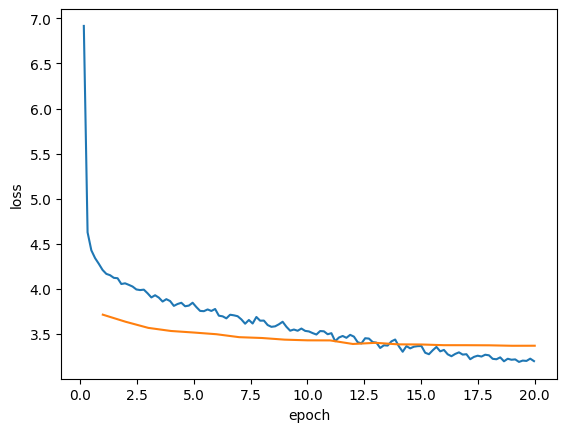

In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

train_log = pd.DataFrame({
    'loss': train_loss,
    'epoch': train_epoch
})
test_log = pd.DataFrame({
    'loss': test_loss,
    'epoch': test_epoch
})

sns.lineplot(
    data=train_log,
    x='epoch',
    y='loss'
)
sns.lineplot(
    data=test_log,
    x='epoch',
    y='loss'
)

plt.show()

Можно сказать, что модель достигла максимума, так как на валидационном датасете изменений нет, если продолжить обучения есть риск начала переобучения